## Assignment

已知肌肉收缩图像序列和对应的力量输出 `fem.mat`。<br>
请处理每帧图像，计算得到其中羽状角(pennation angle)的角度并与力量一起绘制曲线做对比。

## 1. What is pennation angle ?

<img src="https://static-content.springer.com/esm/art%3A10.1186%2F1475-925X-11-63/MediaObjects/12938_2012_560_MOESM1_ESM.png" 
alt="Pennation angle" width="400" height="300" align="left" />

## 2. Detect edges

### (1) Read images

set parameters of `plt` 

In [19]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.cmap']='gray'

read into `images` array

In [20]:
import os
import numpy as np

pattern = 'data_ex4/bmc{}.bmp'
images = np.array([io.imread(pattern.format(i + 1)) for i in range(500)])

Define helper function for visualization.

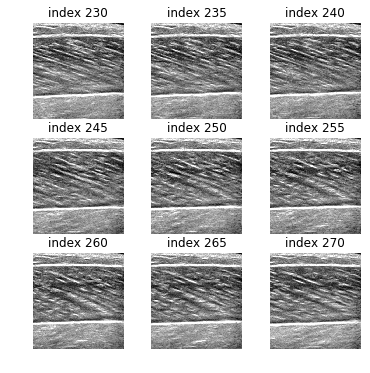

In [21]:
def snapshots(images, rows=3, cols=3, step=5):
    
    # compute intervals
    depth = images.shape[0]
    begin = depth // 2 - step * (rows * cols // 2)
    
    fig, ax = plt.subplots(rows, cols, figsize=[rows*2, cols*2])
    for i in range(rows * cols):
        idx = begin + i * step
        ax[i // rows, i % rows].set_title('index %d' % idx)
        ax[i // rows, i % rows].imshow(images[idx])
        ax[i // rows, i % rows].axis('off')
    plt.show()

snapshots(images)

### (2) `Canny` filter

select one image for trail

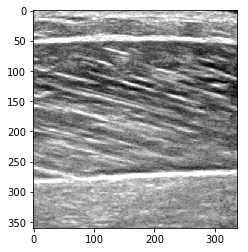

In [22]:
im = images[0]
plt.imshow(im)

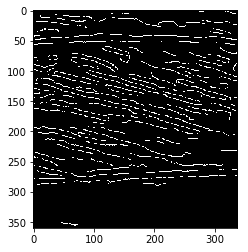

In [23]:
from skimage.feature import canny

bw = canny(im, sigma=3)
plt.imshow(bw);

## Hough transform

In [24]:
from skimage.transform import hough_line
from skimage.transform import hough_line_peaks

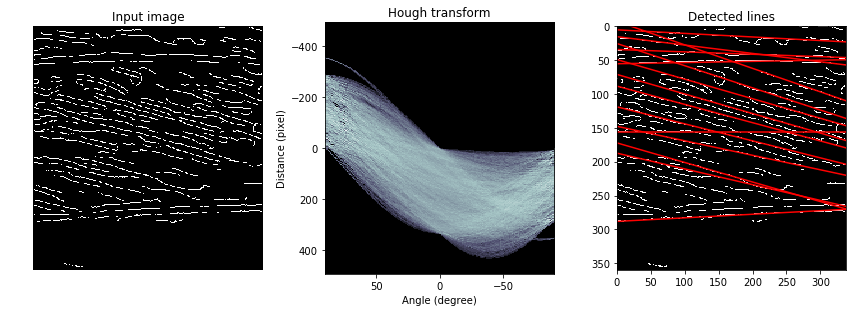

In [25]:
out, angles, dists = hough_line(bw)

fig, axes = plt.subplots(1, 3, figsize=(12, 9), subplot_kw={'adjustable': 'box-forced'})

axes[0].imshow(bw, cmap=plt.cm.gray)
axes[0].set_title('Input image')
axes[0].set_axis_off()

axes[1].imshow(np.log(out + 1), cmap=plt.cm.bone, aspect=1/5, 
               extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), dists[-1], dists[0]])
axes[1].set_title('Hough transform')
axes[1].set_xlabel('Angle (degree)')
axes[1].set_ylabel('Distance (pixel)')

axes[2].imshow(bw, cmap=plt.cm.gray)
rows, cols = bw.shape
for _, angle, dist in zip(*hough_line_peaks(out, angles, dists)):
    # choose the leftmost points and rightmost points
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    axes[2].plot((0, cols), (y0, y1), '-r')
    axes[2].axis((0, cols, rows, 0))
    axes[2].set_title('Detected lines')
    # axes[2].set_axis_off()

plt.tight_layout()
plt.show()

### Discussion 

1. When apply `Canny` filter we should carefully choose the value of `sigma`. <br>
    But considering the homogeneous images in this experiment, I suppose `sigma = 4.5` could be generalized.
2. Draw detected lines in binary images, we need to convert from **polar** coordinate to **Cartesian** coordinate. 
    <img src="http://zone.ni.com/images/reference/en-XX/help/372916L-01/edge_hough_localize.gif" 
    alt="Hough Transform" width="600" height="400" align="left" />

$\qquad \quad y = - \dfrac{cos(\theta)}{sin(\theta)}\cdot x + \dfrac{r}{sin(\theta)}$

## Compute pennation angle

Change angles to be included angles of slope which is still in range $[-\dfrac {\pi}{2}, \dfrac {\pi}{2}]$.

In [26]:
_, angles, dists = hough_line_peaks(*hough_line(bw))
theta = np.rad2deg([-(np.pi/2 + a) if a < 0 else np.pi/2 - a for a in angles])

### Referenced line 

It should has positive angle and the distance is longer than `rows / 2`.

In [27]:
reference = np.mean([a for a, d in zip(theta, abs(dists)) if 2 * d > bw.shape[0] and 0 < a < 10])
print('reference angle(in degree): %g' % reference)

reference angle(in degree): 3.01676


### Target line

In [28]:
diff = reference - theta
pennation = np.mean(abs(diff[diff > 15]))
print('pennation angle(in degree): %g' % pennation)

pennation angle(in degree): 18.5475


## Process all frames

In [29]:
pa = np.zeros(images.shape[0])

for idx, im in enumerate(images):
    bw = canny(im, sigma=4)
    _, angles, dists = hough_line_peaks(*hough_line(bw))
    theta = np.rad2deg([-(np.pi/2 + a) if a < 0 else np.pi/2 - a for a in angles])
    reference = np.mean([a for a, d in zip(theta, abs(dists)) if 2 * d > bw.shape[0] and 0 < a < 10])
    diff = reference - theta
    pennation = np.mean(abs(diff[diff > 16]))
    pa[idx] = pennation

C:\Anaconda2\envs\python35\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda2\envs\python35\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Uses interpolation to approximate the value of  `nan` 

In [30]:
from scipy import interpolate

def fill_nan(ar):
    inds = np.arange(ar.shape[0])
    good = np.where(np.isfinite(ar))
    f = interpolate.interp1d(inds[good], ar[good], kind='cubic', bounds_error=False)
    ar_filled = np.where(np.isfinite(ar), ar, f(inds))
    return ar_filled, f

In [31]:
pa_new, f = fill_nan(pa)
x = np.arange(0, pa_new.size, 0.2)

smooth the curve

In [32]:
from scipy.signal import savgol_filter
pa_smoothed = savgol_filter(pa_new, 51, 2)

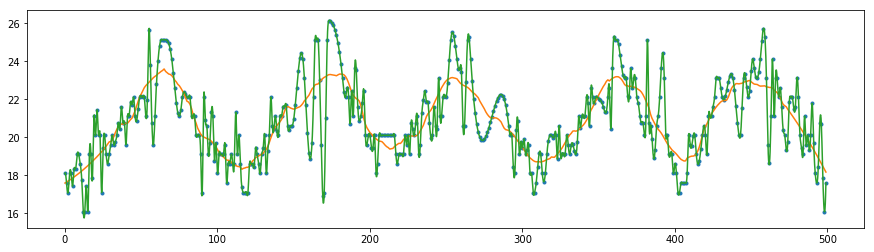

In [33]:
plt.figure(figsize=(15, 4))
plt.plot(range(pa.size), pa_new, '.', range(pa.size), pa_smoothed, x, f(x));

## Compare with `fem.mat`

### load `mat` file

In [34]:
import scipy.io as sio

force, time = [sio.loadmat('data_ex4/fem.mat')[key].squeeze() for key in ['force', 'time2']]

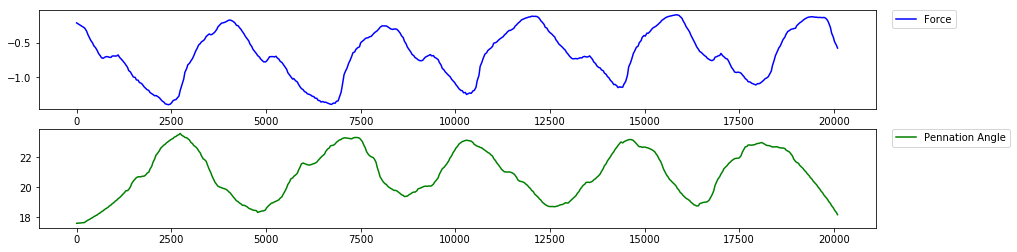

In [35]:
plt.figure(figsize=(15, 4))

plt.subplot(211)
plt.plot(time, force, 'b-', label='Force')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(212)
plt.plot(time, pa_smoothed, 'g-', label='Pennation Angle');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.show()

### Discussion

The above picture shows the remarkable **negative** correlation. <br>
However, it should be proved that pennation angle is **proportional** to force, basically.   
So I guess the negative sign in `force` may be the proper explanation. 


## Advanced Process: Neural Network

### Make labels

In [45]:
y_true = pa_smoothed[:200]

In [47]:
with open('y_true.txt', 'w+') as f:
    for idx, angle in enumerate(y):
        f.writelines([str(idx + 1), ' ', str(np.round(angle, 1)), '\n'])

In [52]:
np.save('y_val', pa_smoothed[200: 300])

In [48]:
images.shape

(500, 360, 338)

In [49]:
np.std(images)

45.737053285772532

In [50]:
np.mean(images)

143.21446919789611